In [34]:
!pip install torch torchvision transformers
!nvidea-smi

/bin/bash: nvidea-smi: command not found


In [35]:
from torchvision.models import resnet50
from transformers import ResNetForImageClassification
import torch.nn as nn
from torchvision import datasets, transforms
import torch
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [36]:
model = resnet50(pretrained=True)

In [37]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='/kaggle/input/medical-wastee/Medical Waste 4.0', transform=transform)


# Obtenir la liste des classes (noms des sous-répertoires)
classes = dataset.classes

# Dictionnaire pour stocker les index des échantillons par classe
class_indices = {class_name: [] for class_name in classes}

# Parcourir le dataset pour obtenir les index des échantillons de chaque classe
for index, (image, label) in enumerate(dataset):
    class_indices[classes[label]].append(index)

# Diviser les index en ensembles d'entraînement, de validation et de test
train_indices = []
val_indices = []
test_indices = []

for class_name, indices in class_indices.items():
    # Mélanger les index pour une répartition aléatoire
    np.random.shuffle(indices)

    # Calculer le nombre d'échantillons pour chaque ensemble
    num_samples = len(indices)
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)
    test_size = num_samples - (train_size + val_size)

    # Répartir les index dans les ensembles
    train_indices.extend(indices[:train_size])
    val_indices.extend(indices[train_size:train_size + val_size])
    test_indices.extend(indices[train_size + val_size:])

# Créer les ensembles d'entraînement, de validation et de test
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Vérification des tailles des ensembles
print(f"Nombre d'échantillons dans l'ensemble d'entraînement : {len(train_dataset)}")
print(f"Nombre d'échantillons dans l'ensemble de validation : {len(val_dataset)}")
print(f"Nombre d'échantillons dans l'ensemble de test : {len(test_dataset)}")

Nombre d'échantillons dans l'ensemble d'entraînement : 2967
Nombre d'échantillons dans l'ensemble de validation : 629
Nombre d'échantillons dans l'ensemble de test : 649


In [38]:

# Nombre total d'étapes
num_steps = 10

# Dictionnaire pour stocker les index des échantillons par classe
class_indices_train = {class_name: [] for class_name in classes}

# Parcourir le dataset pour obtenir les index des échantillons de chaque classe
for index, (image, label) in enumerate(train_dataset):
    class_indices_train[classes[label]].append(index)

# Calculer le nombre total d'échantillons par classe et le nombre minimum d'échantillons par classe
total_samples_per_class = {class_name: len(indices) for class_name, indices in class_indices_train.items()}
min_samples_per_class = min(total_samples_per_class.values())

# Liste pour stocker les datasets progressifs
progressive_datasets = []

# Pour chaque étape
for step in range(1, num_steps):
     # Créer un dictionnaire pour stocker les indices des échantillons à ajouter à chaque classe
    indices_to_add_per_class = {class_name: [] for class_name in classes}
    
    # Pour chaque classe
    for class_name, indices in class_indices_train.items():
        # Déterminer le nombre d'échantillons à ajouter pour cette classe à cette étape
        target_num_samples = int(min_samples_per_class * (step / num_steps))
        
        # Sélectionner les indices des échantillons à ajouter à cette classe
        indices_to_add = indices[:target_num_samples]
        
        # Ajouter les indices sélectionnés à la liste des indices à ajouter pour cette classe
        indices_to_add_per_class[class_name].extend(indices_to_add)
    
    # Concaténer tous les indices à ajouter pour former le nouvel ensemble de données progressif à cette étape
    progressive_indices = sum(indices_to_add_per_class.values(), [])
    
    # Créer un Subset à partir du train_dataset avec les indices mis à jour
    progressive_dataset = Subset(train_dataset, progressive_indices)
    
    # Ajouter le Subset à la liste des datasets progressifs
    progressive_datasets.append(progressive_dataset)

progressive_datasets.append(train_dataset)


In [39]:
batch_size = 32  # Adjust as necessary

val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [40]:
import torch.nn as nn

class CustomResNet(nn.Module):
    def __init__(self, original_model):
        super(CustomResNet, self).__init__()
        self.new_layer = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding=1) # A tester sans cette couche
        self.resnet = nn.Sequential(*list(original_model.children())[:-1]) # Removing original FC layer

        # Add your new FC layer if necessary
        self.fc = nn.Linear(2048, num_classes) # num_classes is the number of your dataset classes

    def forward(self, x):
        x = self.new_layer(x)
        x = self.resnet(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        return x

# Initialize your custom model
num_classes = 13 # Example


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Number of epochs
num_epochs = 10

# List to store the number of samples for each progressive dataset
num_samples = []

# Lists to store training and validation metrics for each progressive dataset
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Lists to store test metrics for each progressive dataset
test_losses = []
test_acc = []

# Lists to store predictions and labels for confusion matrix for each num_samples
all_preds_per_sample = []
all_labels_per_sample = []

for progressive_dataset in progressive_datasets:
    custom_model = CustomResNet(model)
    custom_model.to(device)
    # Loss function
    criterion = nn.CrossEntropyLoss()

    params_to_optimize = custom_model.fc.parameters()
    # Optimizer
    optimizer = torch.optim.Adam(params_to_optimize, lr=1e-3)

    # Number of samples for the current progressive dataset
    num_samples.append(len(progressive_dataset))

    # Create DataLoader for the current progressive dataset
    train_loader = DataLoader(progressive_dataset, batch_size=batch_size, shuffle=True)

    # Initialize lists to store training and validation metrics for each epoch
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    # Initialize lists to store predictions and labels for confusion matrix
    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        # Training phase
        custom_model.train()
        running_loss = 0.0
        correct_preds = 0
        total_train_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = custom_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_train_preds += labels.size(0)

        # Calculate training metrics for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_preds / total_train_preds
        epoch_train_losses.append(epoch_train_loss)
        epoch_train_accs.append(epoch_train_acc)

         # Variables to track progress within an epoch for validation
        val_loss = 0.0
        correct_preds = 0
        total_val_preds = 0

        # Validation phase
        custom_model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = custom_model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate the validation loss and correct predictions
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_val_preds += labels.size(0)

        # Calculate and store validation loss and accuracy for the epoch
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct_preds / total_val_preds
        epoch_val_losses.append(epoch_val_loss)
        epoch_val_accs.append(epoch_val_acc)

        # Clear any outputs from the current cell display
        clear_output(wait=True)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]: '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    # Store the loss and accuracy for the last epoch of the current progressive dataset
    train_losses.append(epoch_train_losses[-1])
    val_losses.append(epoch_val_losses[-1])  # Add validation losses if needed
    train_acc.append(epoch_train_accs[-1])
    val_acc.append(epoch_val_accs[-1])  # Add validation accuracies if needed

    # Test phase
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0

    custom_model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = custom_model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Save predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate test metrics
    test_avg_loss = total_loss / total_samples
    test_accuracy = correct_preds / total_samples

    # Store test metrics
    test_losses.append(test_avg_loss)
    test_acc.append(test_accuracy)

    # Store predictions and labels for confusion matrix for this num_samples
    all_preds_per_sample.append(all_preds)
    all_labels_per_sample.append(all_labels)

    # Print test results
    print(f'Test Loss: {test_avg_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Print summary after all epochs for all progressive datasets
print("\nSummary after all epochs for all progressive datasets:")
print(f"{'Num Samples':^15} | {'Train Loss':^10} | {'Train Acc':^9} | {'Val Loss':^9} | {'Val Acc':^8} | {'Test Loss':^9} | {'Test Acc':^8}")
print("-" * 100)
for i, progressive_dataset in enumerate(progressive_datasets):
    print(f"{num_samples[i]:^15} | {train_losses[i]:^10.4f} | {train_acc[i]:^9.4f} | {val_losses[i]:^9.4f} | {val_acc[i]:^8.4f} | {test_losses[i]:^9.4f} | {test_acc[i]:^8.4f}")


Epoch [10/10]: Train Loss: 0.2156, Train Acc: 0.9309, Val Loss: 0.2432, Val Acc: 0.9157
Test Loss: 0.2550, Test Accuracy: 0.9060

Summary after all epochs for all progressive datasets:
  Num Samples   | Train Loss | Train Acc | Val Loss  | Val Acc  | Test Loss | Test Acc
----------------------------------------------------------------------------------------------------
      273       |   0.5470   |  0.9158   |  0.7440   |  0.8172  |  0.7606   |  0.7966 
      546       |   0.6004   |  0.8755   |  0.5834   |  0.8267  |  0.6176   |  0.8089 
      819       |   0.3370   |  0.9096   |  0.3812   |  0.8617  |  0.4079   |  0.8521 
     1092       |   0.3477   |  0.9249   |  0.3821   |  0.8696  |  0.3836   |  0.8490 
     1365       |   0.2846   |  0.9326   |  0.2864   |  0.9173  |  0.3331   |  0.8783 
     1638       |   0.2875   |  0.9200   |  0.3093   |  0.8728  |  0.3255   |  0.8783 
     1911       |   0.2381   |  0.9236   |  0.2416   |  0.9157  |  0.2698   |  0.9106 
     2184       | 

In [42]:
# Create a dictionary with your data, including training, validation, and test metrics
data = {
    "Num Samples": num_samples,
    "Training Loss": train_losses,
    "Training Accuracy": train_acc,
    "Validation Loss": val_losses,
    "Validation Accuracy": val_acc,
    "Test Loss": test_losses,
    "Test Accuracy": test_acc
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_file_path = '/kaggle/working/training_validation_test_metrics_resnet_not_freezed.csv'
df.to_csv(csv_file_path, index=False)

print(f"Metrics saved to {csv_file_path}")


Metrics saved to /kaggle/working/training_validation_test_metrics_resnet_not_freezed.csv


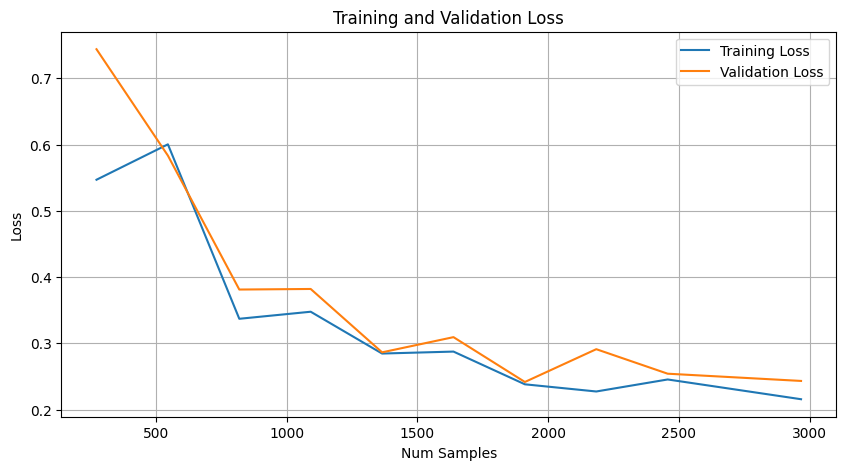

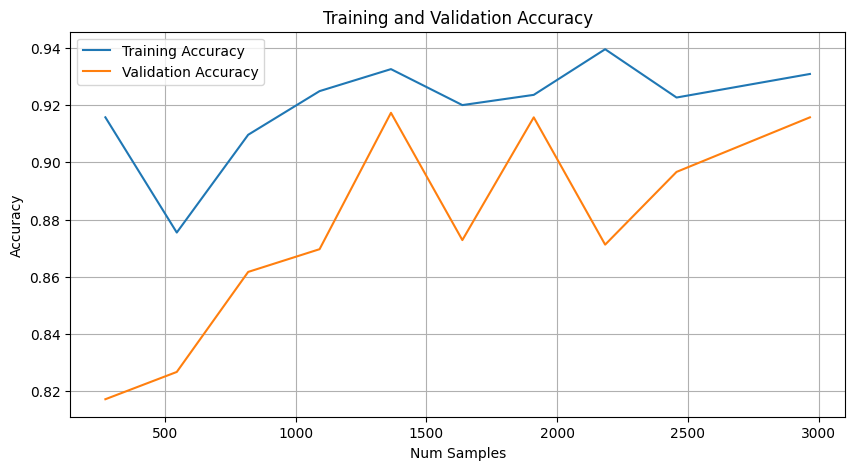

In [43]:
# Plot for the losses
plt.figure(figsize=(10, 5))
plt.plot(num_samples, train_losses, label='Training Loss')
plt.plot(num_samples, val_losses, label='Validation Loss')
plt.xlabel('Num Samples')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_samples, train_acc, label='Training Accuracy')
plt.plot(num_samples, val_acc, label='Validation Accuracy')
plt.xlabel('Num Samples')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


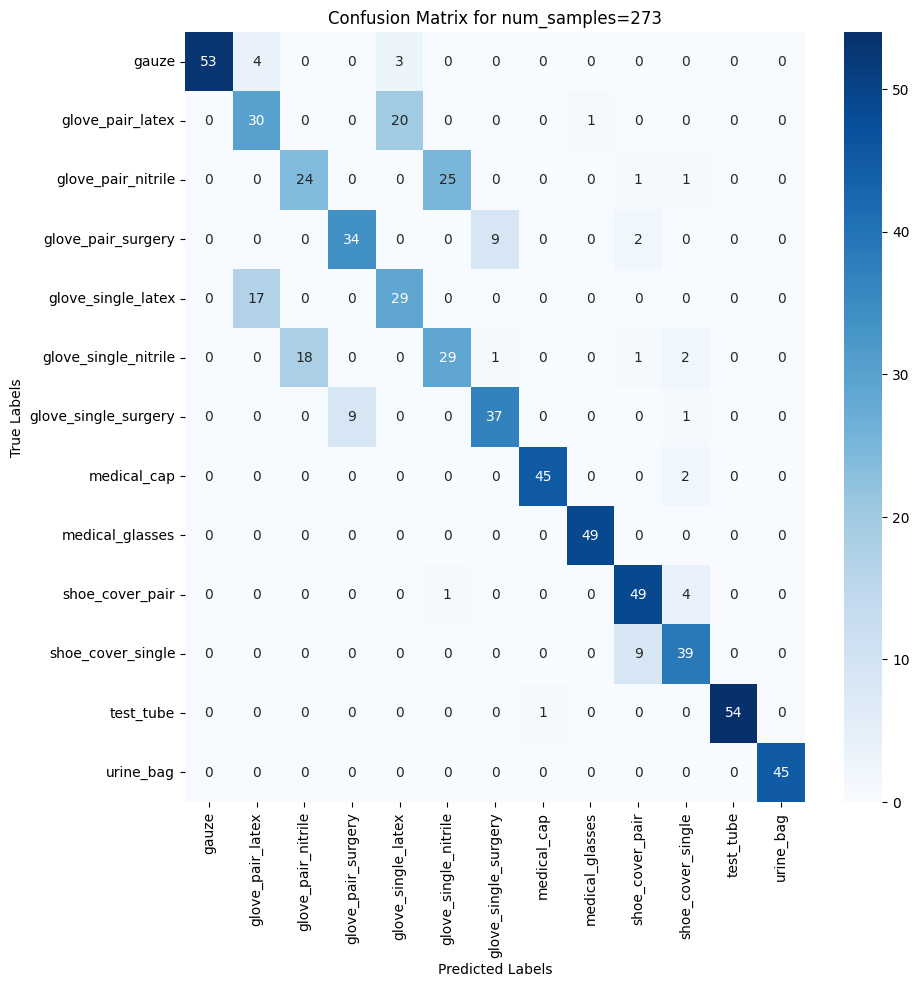

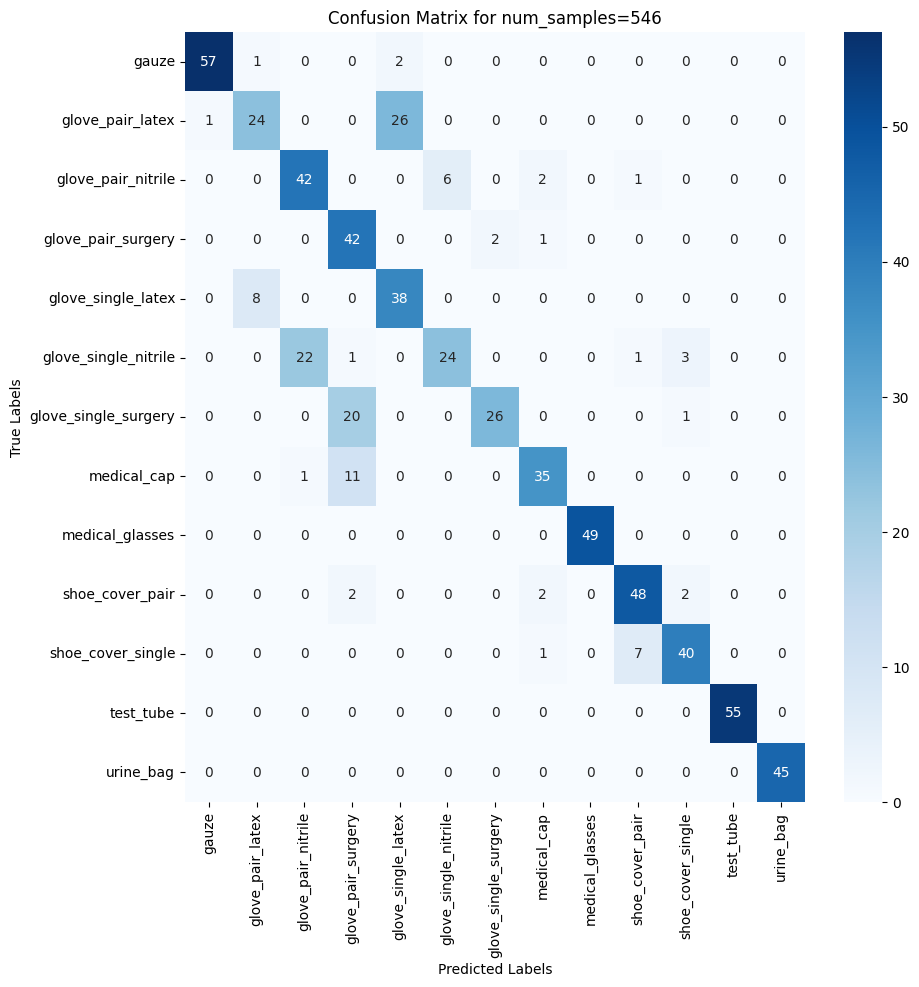

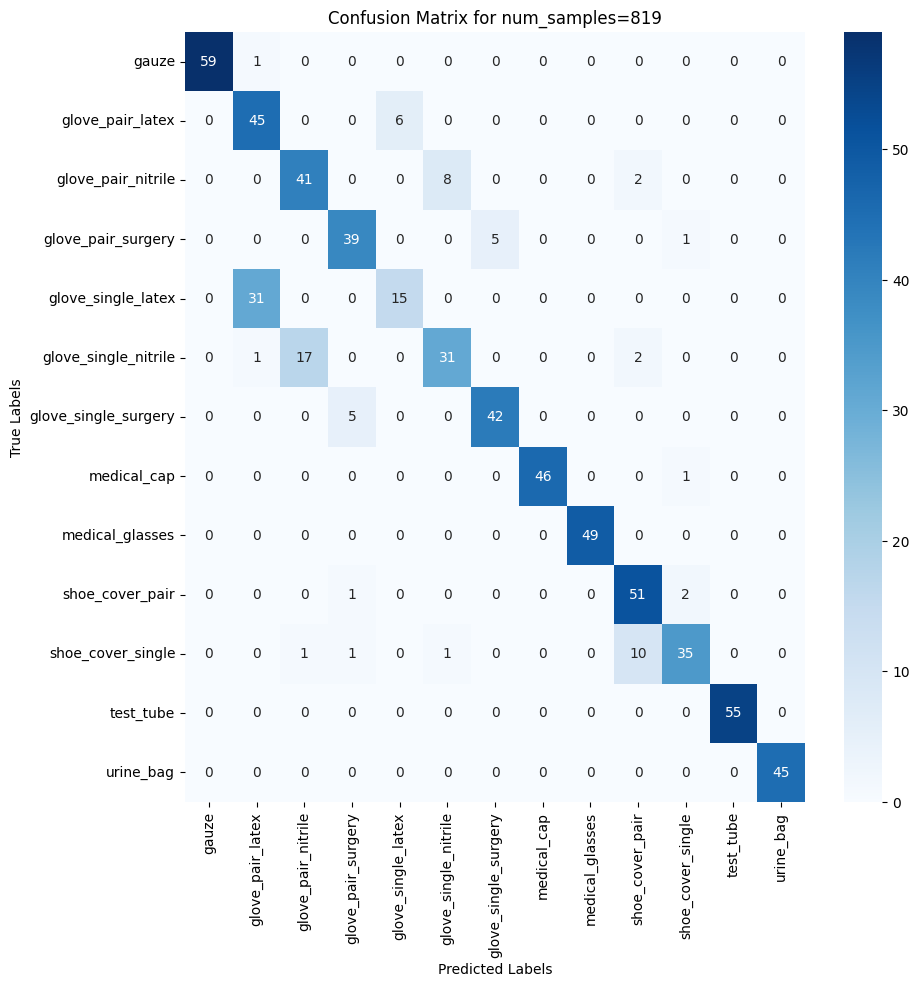

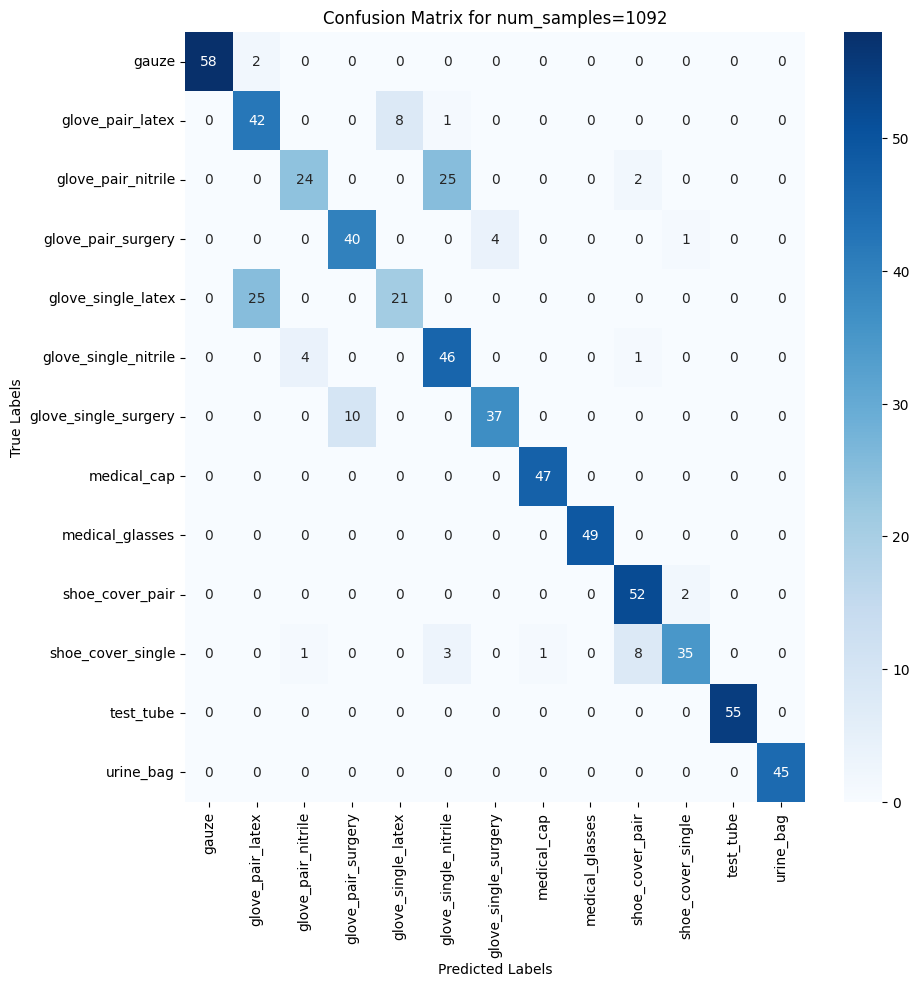

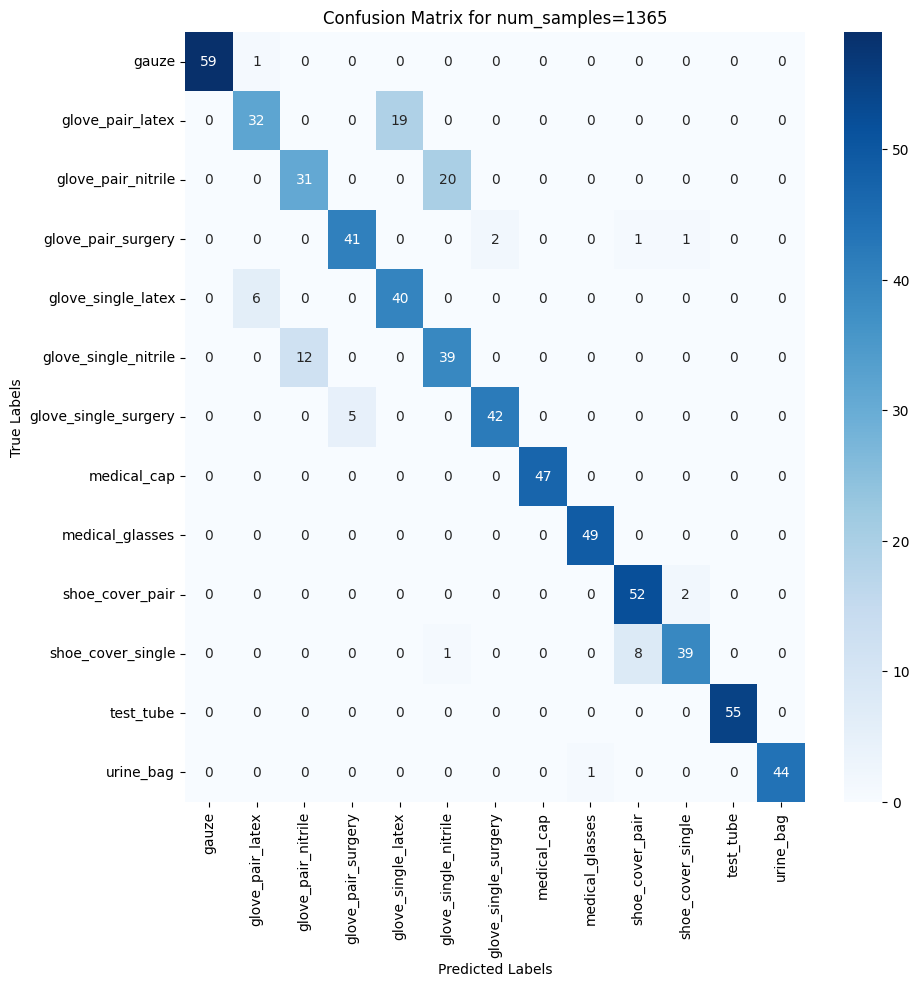

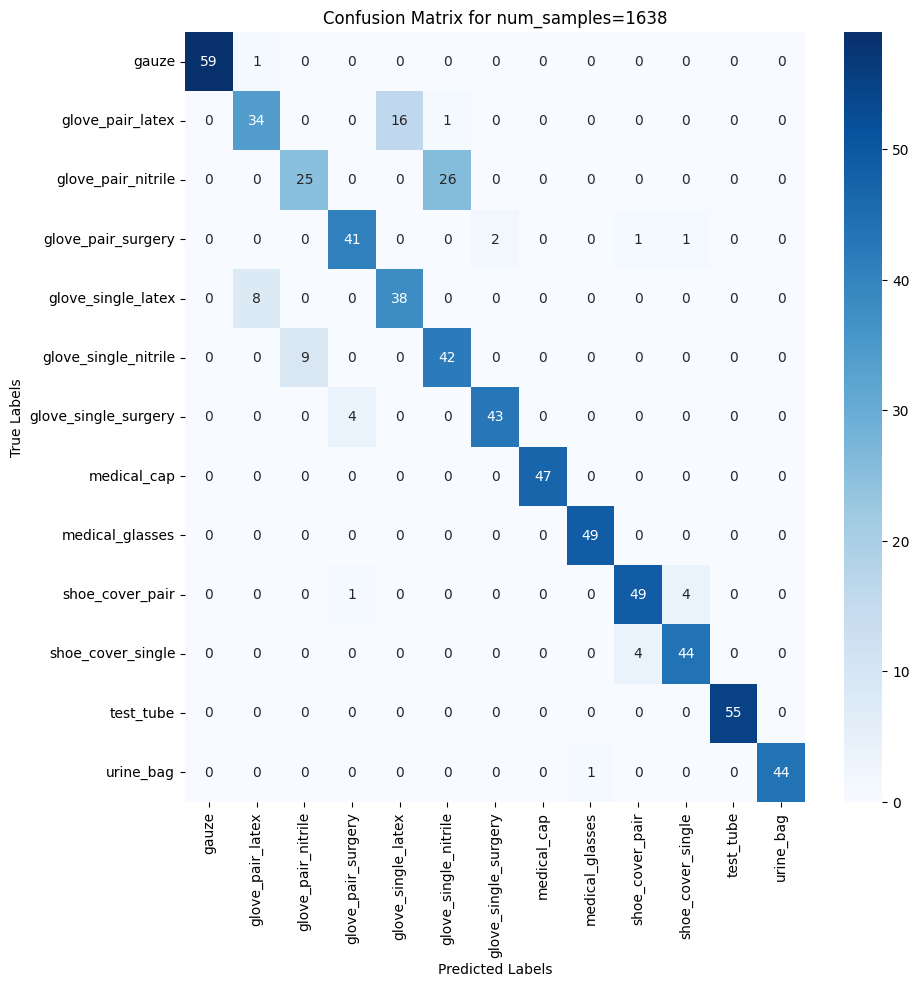

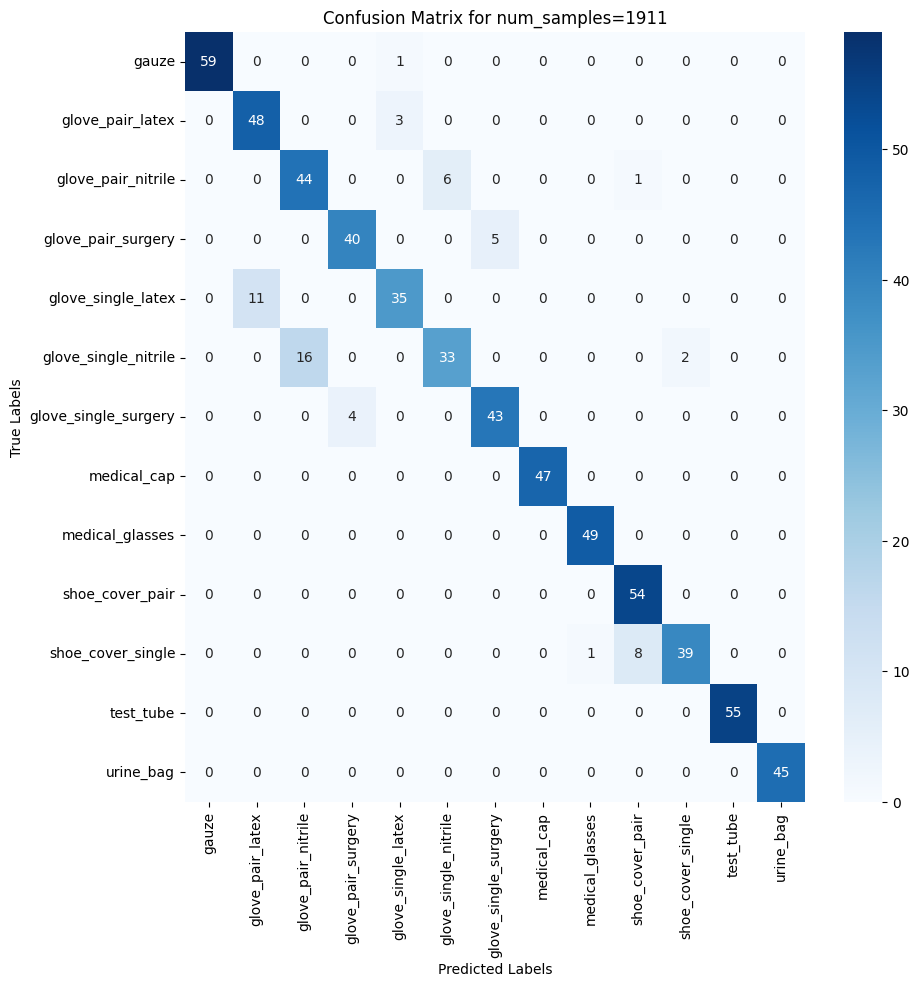

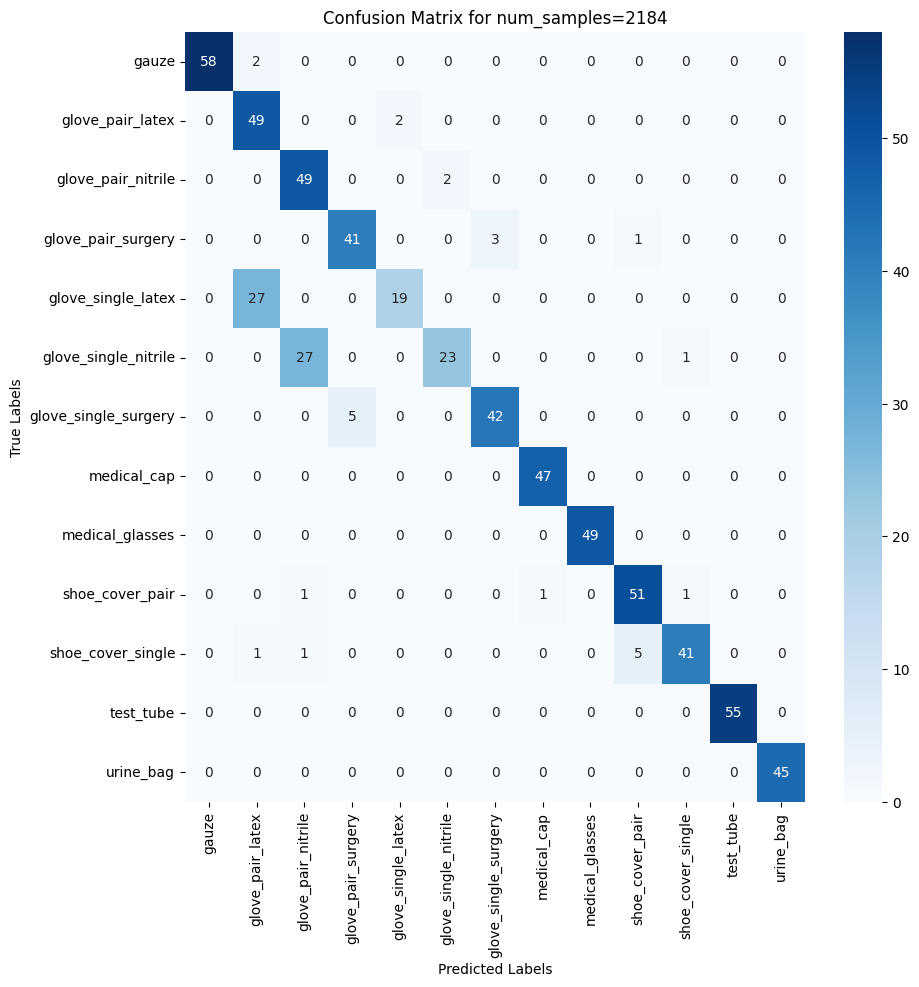

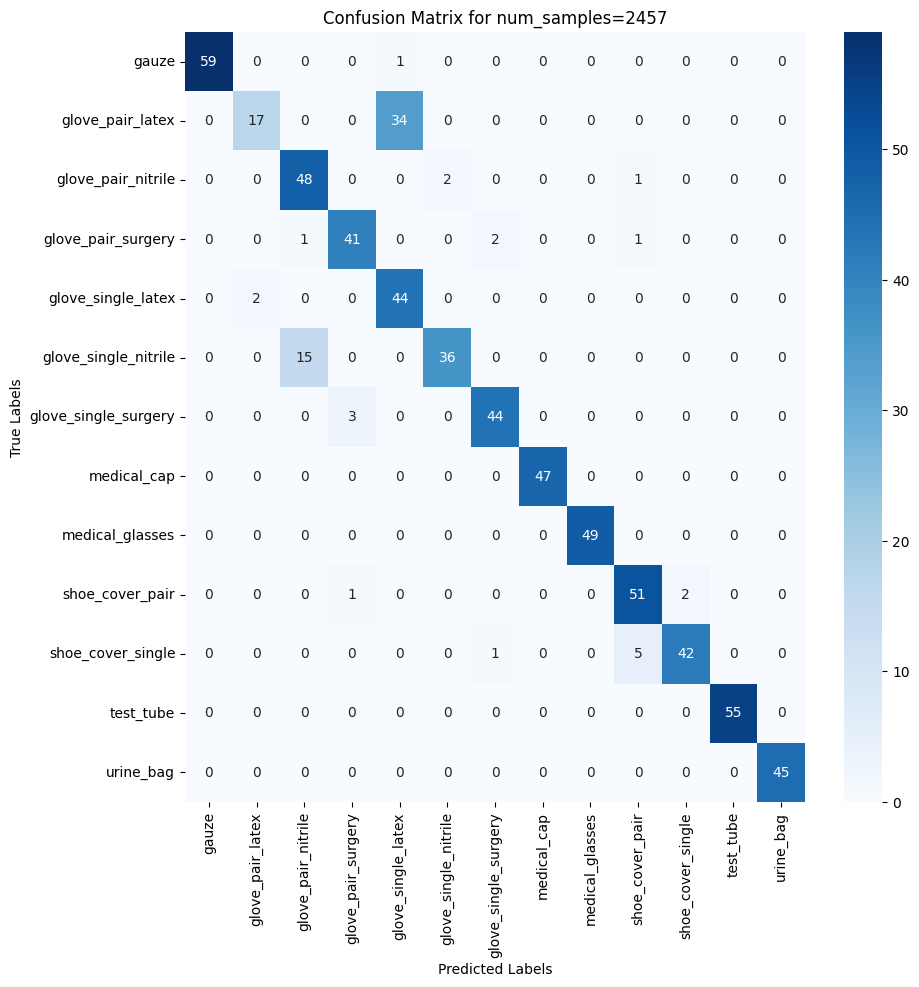

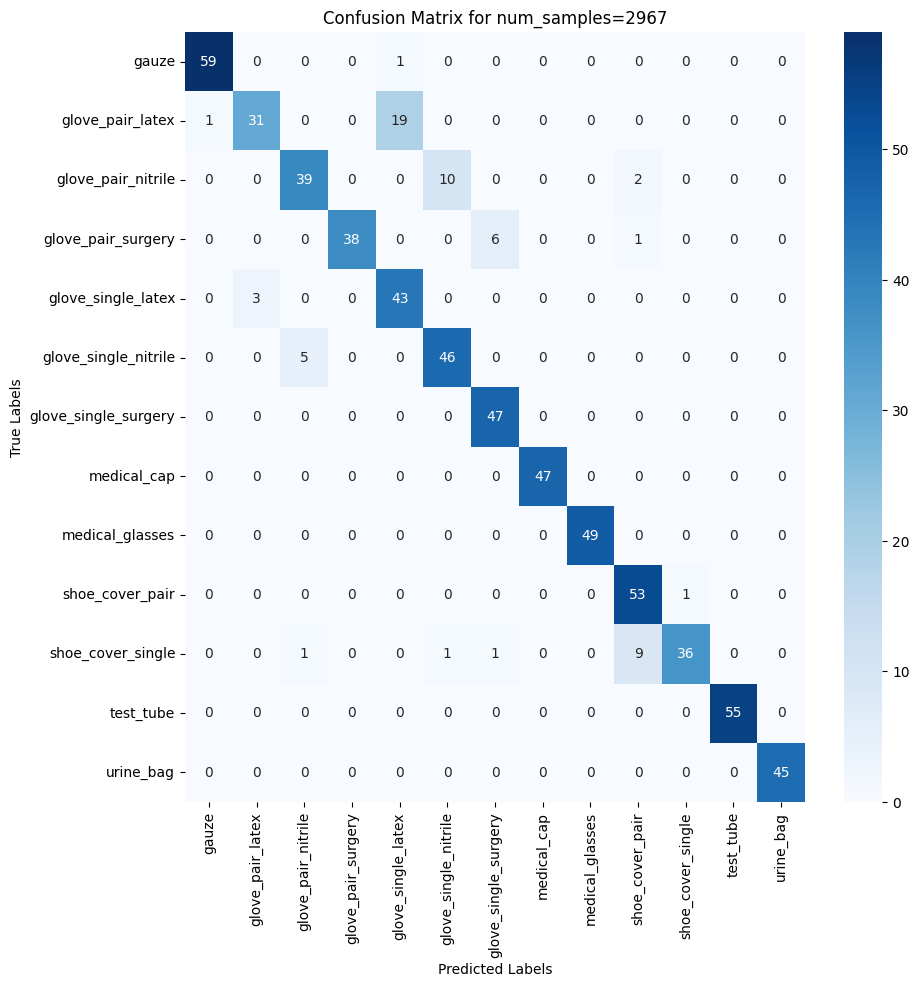

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = dataset.classes

# Iterate through each set of predictions and labels
for i, (preds, labels) in enumerate(zip(all_preds_per_sample, all_labels_per_sample)):
    # Plot the confusion matrix with class names
    conf_matrix = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for num_samples={num_samples[i]}')
    plt.show()


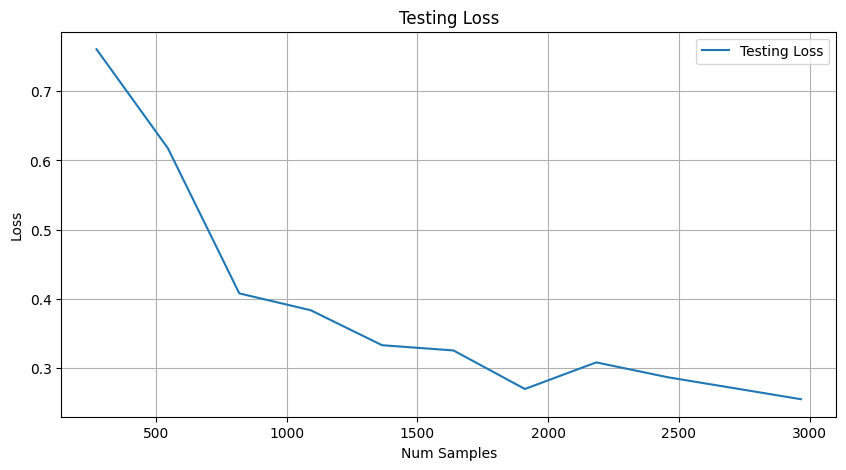

In [45]:
# Plot for the losses
plt.figure(figsize=(10, 5))
plt.plot(num_samples, test_losses, label='Testing Loss')
plt.xlabel('Num Samples')
plt.ylabel('Loss')
plt.title('Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

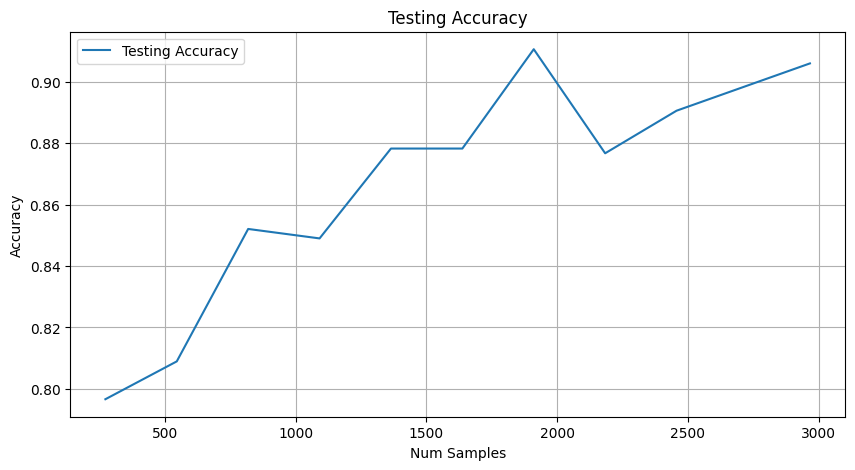

In [46]:
# Plot for the losses
plt.figure(figsize=(10, 5))
plt.plot(num_samples, test_acc, label='Testing Accuracy')
plt.xlabel('Num Samples')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()